In [1]:
!pip install mplcyberpunk

In [2]:
import polars as pl
import polars.selectors as cs
import numpy as np

from keras import layers, Model, optimizers, losses, metrics, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import mplcyberpunk
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('cyberpunk')

2025-08-07 18:49:16.995115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754592557.257096      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754592557.337049      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pl.read_csv('/kaggle/input/intrusion-detection-logs-normal-bot-scan/Network_logs.csv')
df.head()

Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
str,str,i64,str,str,i64,str,str,i64,str
"""192.168.142.55""","""42.156.67.167""",80,"""FTP""","""UDP""",2369,"""curl/7.68.0""","""Success""",0,"""Normal"""
"""53.39.165.18""","""94.60.242.119""",135,"""SMTP""","""UDP""",1536,"""Wget/1.20.3""","""Failure""",1,"""BotAttack"""
"""192.168.127.91""","""7.10.192.3""",21,"""SMTP""","""TCP""",1183,"""Wget/1.20.3""","""Success""",0,"""Normal"""
"""192.168.30.40""","""130.169.82.211""",25,"""HTTPS""","""TCP""",666,"""Mozilla/5.0""","""Success""",0,"""Normal"""
"""192.168.43.179""","""35.140.102.220""",22,"""FTP""","""TCP""",2821,"""Mozilla/5.0""","""Success""",0,"""Normal"""


In [4]:
str_cols = df.select(cs.string())

def ordinal_encode(series : pl.Series) -> dict:
    unique_values = [*series.unique()]
    unique_dict = dict()

    for i in range(len(unique_values)):
        unique_dict[unique_values[i]] = i
    
    return unique_dict

for col in str_cols:
    if col.n_unique() > 10:
        continue
    else:
        mapping = ordinal_encode(col)
        str_cols = str_cols.with_columns(pl.col(col.name).replace(mapping).cast(pl.Float64))

df = df.with_columns(str_cols).cast({cs.numeric() : pl.Float64})
df = df.drop(cs.string())

In [5]:
scaler = MinMaxScaler()

x = df
y = x.drop_in_place('Intrusion')
scaled_x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.10, random_state=42)

In [6]:
models = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'LinearSVC' : LinearSVC(),
    'KNeighborsClassifier' : KNeighborsClassifier()
}

parameters = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'loss': ['log_loss', 'exponential']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'LinearSVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'loss': ['hinge', 'squared_hinge'],
        'penalty': ['l1', 'l2'],
        'dual': [True, False]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'p': [1, 2]
    }
}

In [7]:
preds = {}
accuracies = {}

In [8]:
for model in models.keys():
    current_model = GridSearchCV(
        models[model],
        parameters[model],
        cv=5, n_jobs=-1, verbose=1
    )
    current_model.fit(x_train, y_train)
    current_pred = current_model.predict(x_test)
    preds[model] = current_pred

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [9]:
inputs = layers.Input((x_train.shape[-1],))
x = layers.Dense(units=32, activation='relu')(inputs)
x = layers.Dense(units=64, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)

keras_model = Model(inputs, outputs)
keras_model.summary()

2025-08-07 18:55:14.518506: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
keras_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[metrics.BinaryAccuracy()]
)

early_stopping = callbacks.EarlyStopping(
    patience=10
)

plateau = callbacks.ReduceLROnPlateau(
    patience=10
)

history = keras_model.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, plateau]
)

Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.9365 - loss: 0.2458 - val_binary_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 0.0017 - val_binary_accuracy: 1.0000 - val_loss: 3.7290e-04 - learning_rate: 0.0010
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 2.9149e-04 - val_binary_accuracy: 1.0000 - val_loss: 1.1304e-04 - learning_rate: 0.0010
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 9.9016e-05 - val_binary_accuracy: 1.0000 - val_loss: 5.2768e-05 - learning_rate: 0.0010
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 4.3966e-05 - val_binary_accuracy: 1.0000 - val_loss: 2.9804e-05 - learning_rate: 0.0010
Epoch 6/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 2.3457e-05 - val_binary_accuracy: 1.0000 - val_los

In [11]:
keras_pred = keras_model.predict(x_test)
preds['Keras'] = np.array((keras_pred > 0.5), np.float64).squeeze()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


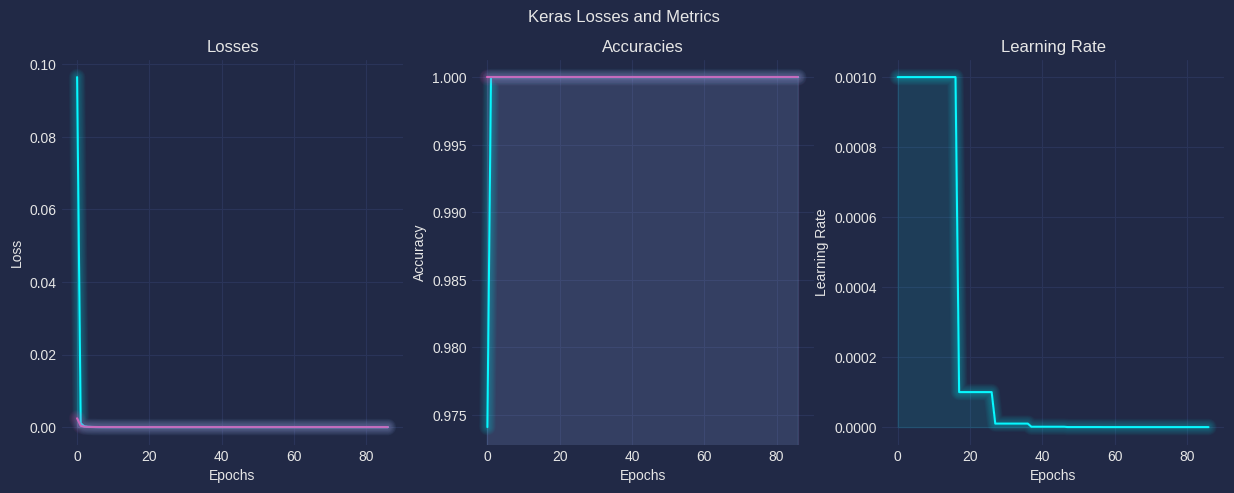

In [12]:
keras_history = history.history
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Keras Losses and Metrics')

ax[0].plot(keras_history['loss'])
ax[0].plot(keras_history['val_loss'])
ax[0].set_title('Losses')
ax[0].set_ylabel('Loss')

ax[1].plot(keras_history['binary_accuracy'])
ax[1].plot(keras_history['val_binary_accuracy'])
ax[1].set_title('Accuracies')
ax[1].set_ylabel('Accuracy')

ax[2].plot(keras_history['learning_rate'])
ax[2].set_title('Learning Rate')
ax[2].set_ylabel('Learning Rate')

for i in range(3):
    ax[i].set_xlabel('Epochs')
    mplcyberpunk.make_lines_glow(ax=ax[i])
    mplcyberpunk.add_underglow(ax=ax[i])

In [13]:
target_names = ['Normal', 'Attack']

for model in preds:
    current_pred = preds[model]
    cr = classification_report(y_test, current_pred, target_names=target_names)
    accuracies[model] = accuracy_score(y_test, current_pred)
    print(f'Classification Report for {model}\n {cr}')

Classification Report for RandomForestClassifier
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       798
      Attack       1.00      1.00      1.00        87

    accuracy                           1.00       885
   macro avg       1.00      1.00      1.00       885
weighted avg       1.00      1.00      1.00       885

Classification Report for GradientBoostingClassifier
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       798
      Attack       1.00      1.00      1.00        87

    accuracy                           1.00       885
   macro avg       1.00      1.00      1.00       885
weighted avg       1.00      1.00      1.00       885

Classification Report for LogisticRegression
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       798
      Attack       1.00      1.00      1.00        87

    accuracy                    

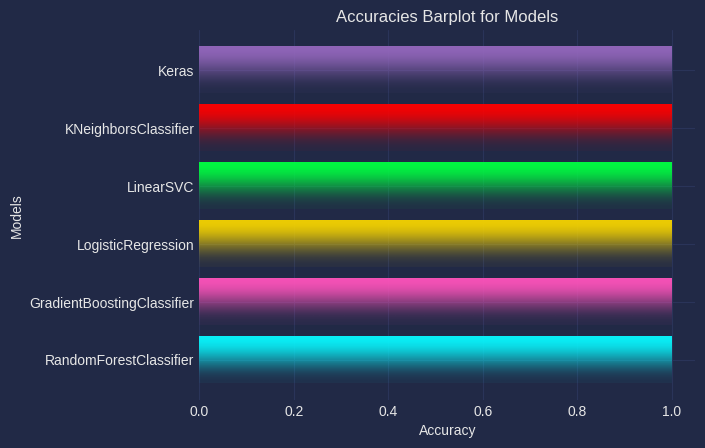

In [14]:
colors = ["C0", "C1", "C2", "C3", "C4", "C5"]

plt.title('Accuracies Barplot for Models')
plt.xlabel('Accuracy')
plt.ylabel('Models')
bars = plt.barh(list(accuracies.keys()), list(accuracies.values()), color=colors)
mplcyberpunk.add_bar_gradient(bars)

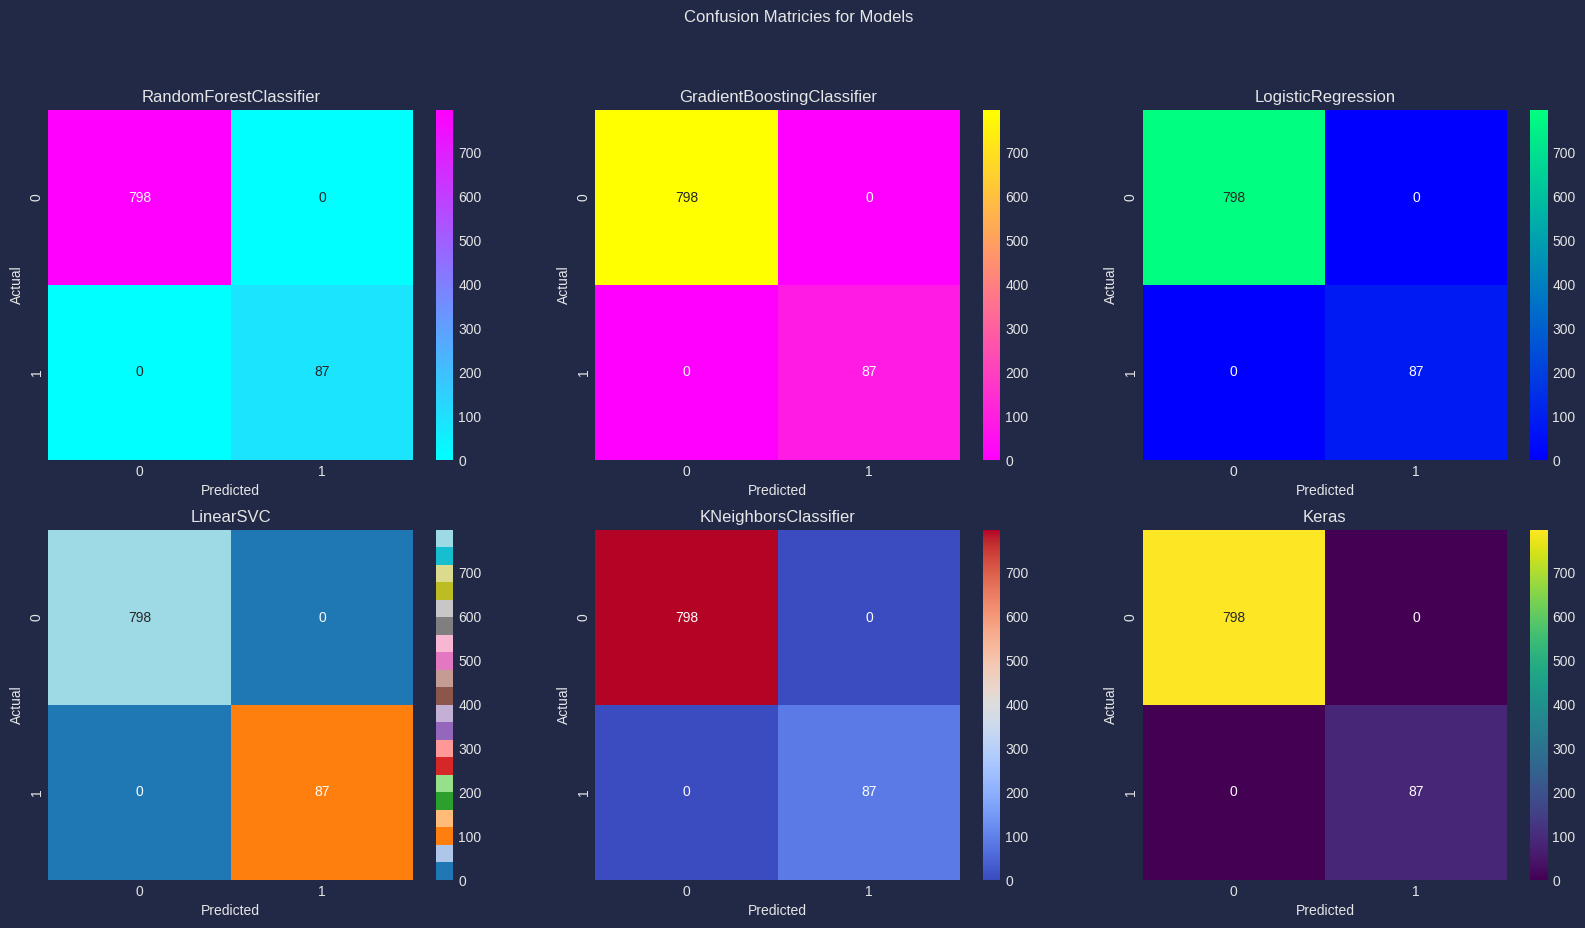

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle("Confusion Matricies for Models")
cmaps = ['cool', 'spring', 'winter', 'tab20', 'coolwarm', 'viridis']

for idx, col in enumerate(preds):
    axes = ax[idx // 3, idx % 3]
    axes.set_title(col)
    cm = confusion_matrix(y_test, preds[col])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx], ax=axes)
    axes.set_ylabel('Actual')
    axes.set_xlabel('Predicted')